# Data Description  


*   UA, STEMI, NSTEMI and controls.
*   The cases and controls were classified
into clopidogrel metabolic groups based on genotypes and allele combinations.  
*   ULTRA: * 1/* 17 and * 17/* 17
*   EXTENSIVE: * 1/* 1
*   INTERMEDIATE: *1/*2, *1/*3 , *2/*17, *3 /  *17
*   POOR: * 2/* 2, * 2/* 3 , * 3/* 3-not in sample


In [ ]:
from google.colab import files
files_uploaded = files.upload()

# Steps

# 0. Preprocess + EDA + Feature Selection
# 1. Extract input and output cols
# 2. Scale the values
# 3. Train test split
# 4. Train the model
# 5. Evaluate the model/model selection
# 6. Deploy the model  



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, matthews_corrcoef, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate


In [2]:
url = "https://docs.google.com/spreadsheets/d/1uuL_Yz_w_y09h-uWcVOsTfhyvCwT8LDuvCyhf72LzbQ/export?format=csv"
df = pd.read_csv(url)
df

,Sample Name,CYP2C19 Allele *2,CYP2C19 Allele *3,CYP2C19 Allele *17,FINAL CODE,Metabolisation Status
0,sample 1,AG,GG,TC,UA,Intermediate
1,sample 2,AG,GG,TC,STEMI,Intermediate
2,sample 3,GG,GG,CC,UA,Extensive
3,sample 4,AG,GG,CC,STEMI,Intermediate
4,sample 5,AG,GG,CC,STEMI,Intermediate
...,...,...,...,...,...,...
1186,sample 1187,GG,GG,CC,Controls,Extensive
1187,sample 1188,AG,GG,TC,Controls,Intermediate
1188,sample 1189,GG,GG,TC,Controls,Ultra
1189,sample 1190,AG,GG,CC,Controls,Intermediate


In [3]:
for col in df.columns:
  print(f'{col}: {df[col].unique()}\n')

Sample Name: ['sample 1' 'sample 2' 'sample 3' ... 'sample 1189' 'sample 1190'
 'sample 1191']

CYP2C19 Allele *2: ['AG' 'GG' 'AA']

CYP2C19 Allele *3: ['GG' 'AG']

CYP2C19 Allele *17: ['TC' 'CC' 'TT']

FINAL CODE: ['UA' 'STEMI' 'NSTEMI' 'Controls']

Metabolisation Status: ['Intermediate' 'Extensive' 'Poor' 'Ultra']



In [4]:
########################
####  Data Cleaning ####
########################


# Creating custom transformer for accessing genotype information
class GenotypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, al_col2, al_col3, al_col17):
        self.al_col2 = al_col2
        self.al_col3 = al_col3
        self.al_col17 = al_col17


    def fit(self, X, y=None):
        return self

    def get_genotype(self,X):
            allele_2 = X[self.al_col2]
            allele_3 = X[self.al_col3]
            allele_17 = X[self.al_col17]

            if allele_17 == "TT":
                return "*17/*17"
            elif allele_2 == "AA":
                return "*2/*2"
            elif allele_3 == "AA":
                return "*3/*3"

            # STAR 2
            if allele_2 == "AG":
                if allele_17 == "TC":
                    return "*2/*17"
                elif allele_3 == "AG":
                    return "*2/*3"
                else:
                    return "*1/*2"  #Default case for allele_2 == "AG"

            # STAR 3
            if allele_3 == "AG":
                if allele_17 == "TC":
                    return "*3/*17"
                else:
                    return "*1/*3"  #Default case for allele_3 == "AG"

            # 1/17
            if allele_17 == "TC" and allele_2 == "GG" and allele_3 == "GG":
                return "*1/*17"

            # Default
            return "*1/*1"

    def transform(self, X, y=None):
          X_ = X.copy()
          X_["genotype"] = X_.apply(self.get_genotype, axis=1)
          X_.drop(columns= [self.al_col2, self.al_col3, self.al_col17], inplace =True)
          return X_


########################################
#### Prepare test and training sets ####
########################################


# Split the original dataset into test and training set. Set aside the test set.
X = df.drop(columns=[ 'Metabolisation Status', 'Sample Name'])
y = df["Metabolisation Status"].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
	X_train, X_test = X.loc[train_index], X.loc[test_index] #features split into two
	y_train, y_test = y.loc[train_index], y.loc[test_index] #target split into two

# build preprocessing pipeline
prepro_pipe = Pipeline(steps=[
    ('gen', GenotypeTransformer("CYP2C19 Allele *2","CYP2C19 Allele *3","CYP2C19 Allele *17")),
    ('ohe', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
    ])


# fitting preprocessing pipeline
X_train = prepro_pipe.fit_transform(X_train)
X_test = prepro_pipe.transform(X_test)

C:\Users\Ananya\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [5]:
# initiating base models

knn = KNeighborsClassifier(n_neighbors = 3)
svm = LinearSVC(multi_class='ovr',random_state = 42)
logreg = LogisticRegression(multi_class='ovr', random_state= 42)
nb = BernoulliNB()
tree = DecisionTreeClassifier(random_state=42, max_depth = 4 )
rf = RandomForestClassifier(random_state = 42, max_features= 'sqrt')
grdbst = GradientBoostingClassifier(max_depth = 1, random_state =42)
sgd = SGDClassifier(random_state = 42) #automatically uses ova
adab = AdaBoostClassifier(random_state =42)
mlp = MLPClassifier(solver='lbfgs', random_state=42)


base_models = [
    ('KNN', knn),
    ('SVM', svm),
    ('Logistic Regression', logreg),
    ("Naive Bayes",nb),
    ('Decision Tree', tree),
    ("Random Forest" ,rf),
    ('Gradient Boost', grdbst),
    ("Stochastic Gradient Descent", sgd),
    ("Adaboost", adab),
    ("MLP", mlp)

]


In [6]:
# cross validate

cv_results_list = []

for name, model in base_models:
   cv = cross_validate(model, X= X_train, y= y_train, cv=10, n_jobs =-1,
                        scoring={'accuracy': 'accuracy',
                                 'recall': 'recall_weighted',
                                 'f1': 'f1_weighted'},
                        return_train_score=False)
   accuracy_mean = cv['test_accuracy'].mean()
   recall_mean = cv['test_recall'].mean()
   f1_mean = cv["test_f1"].mean()
   cv_results_list.append([name, accuracy_mean, recall_mean,f1_mean])


cv_res = pd.DataFrame(cv_results_list, columns=["Model", "Accuracy", " Recall", "F1"])
print("cross validation results")
cv_res

cross validation results


,Model,Accuracy,Recall,F1
0,KNN,0.996386,0.996386,0.996293
1,SVM,0.998795,0.998795,0.998798
2,Logistic Regression,0.996386,0.996386,0.996293
3,Naive Bayes,0.996386,0.996386,0.996293
4,Decision Tree,0.949627,0.949627,0.949196
5,Random Forest,0.996386,0.996386,0.996293
6,Gradient Boost,0.998795,0.998795,0.998798
7,Stochastic Gradient Descent,0.998795,0.998795,0.998798
8,Adaboost,0.656670,0.656670,0.538030
9,MLP,0.998795,0.998795,0.998798


In [7]:
# List for scores
base_scores = []

# fit, accuracy scores, pred
for name, model in base_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    mcc = matthews_corrcoef(y_test, y_pred)

    # models use predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = model.decision_function(X_test)

    auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
    base_scores.append([name, train_accuracy, test_accuracy, mcc, auc])

base_results = pd.DataFrame(base_scores, columns=["Model", "Train Accuracy", "Test Accuracy", "MCC", "AUC"])
print("Prediction accuracy of models")
base_results

Prediction accuracy of models


,Model,Train Accuracy,Test Accuracy,MCC,AUC
0,KNN,0.996399,0.986034,0.980146,0.998603
1,SVM,1.000000,0.997207,0.996002,0.999515
2,Logistic Regression,0.996399,0.986034,0.980146,0.999234
3,Naive Bayes,0.996399,0.986034,0.980146,0.998212
4,Decision Tree,0.949580,0.916201,0.887248,0.966861
5,Random Forest,1.000000,0.997207,0.996002,0.998603
6,Gradient Boost,1.000000,0.997207,0.996002,0.999103
7,Stochastic Gradient Descent,1.000000,0.997207,0.996002,0.998677
8,Adaboost,0.656663,0.656425,0.576858,0.764478
9,MLP,1.000000,0.997207,0.996002,0.999515


Classification Report for KNN

              precision    recall  f1-score   support

   Extensive       0.95      1.00      0.98       100
Intermediate       1.00      0.98      0.99       137
        Poor       1.00      0.91      0.95        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           0.99       358
   macro avg       0.99      0.97      0.98       358
weighted avg       0.99      0.99      0.99       358





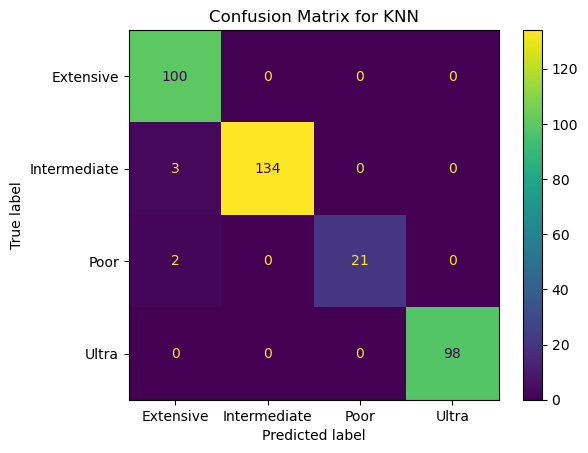


Classification Report for SVM

              precision    recall  f1-score   support

   Extensive       0.99      1.00      1.00       100
Intermediate       1.00      0.99      1.00       137
        Poor       1.00      1.00      1.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358





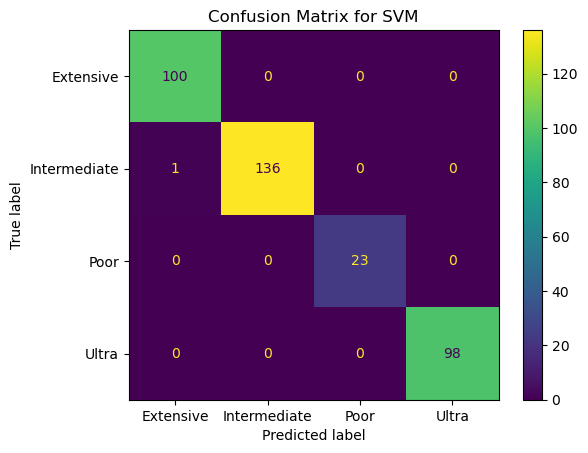


Classification Report for Logistic Regression

              precision    recall  f1-score   support

   Extensive       0.95      1.00      0.98       100
Intermediate       1.00      0.98      0.99       137
        Poor       1.00      0.91      0.95        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           0.99       358
   macro avg       0.99      0.97      0.98       358
weighted avg       0.99      0.99      0.99       358





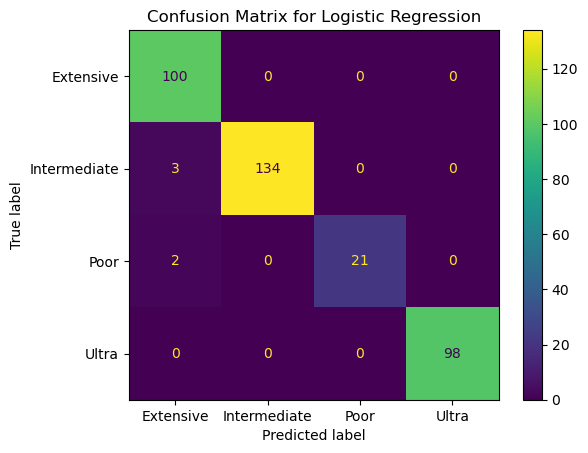


Classification Report for Naive Bayes

              precision    recall  f1-score   support

   Extensive       0.95      1.00      0.98       100
Intermediate       1.00      0.98      0.99       137
        Poor       1.00      0.91      0.95        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           0.99       358
   macro avg       0.99      0.97      0.98       358
weighted avg       0.99      0.99      0.99       358





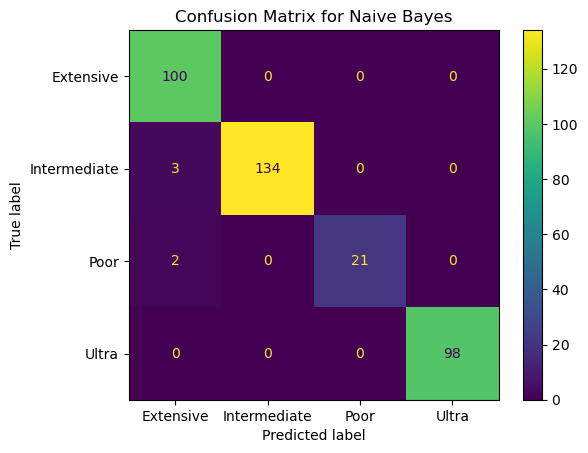


Classification Report for Decision Tree

              precision    recall  f1-score   support

   Extensive       0.77      1.00      0.87       100
Intermediate       1.00      0.98      0.99       137
        Poor       1.00      0.91      0.95        23
       Ultra       1.00      0.74      0.85        98

    accuracy                           0.92       358
   macro avg       0.94      0.91      0.92       358
weighted avg       0.94      0.92      0.92       358





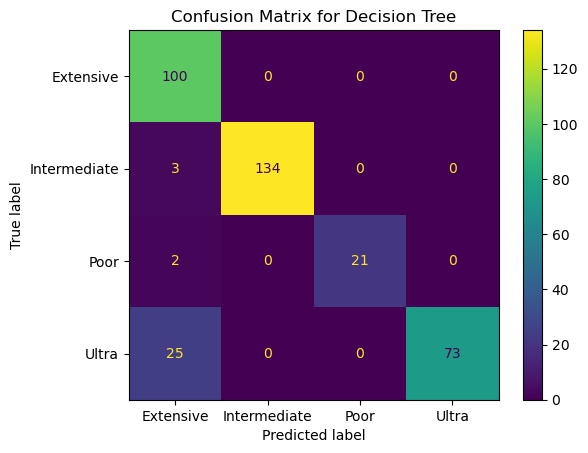


Classification Report for Random Forest

              precision    recall  f1-score   support

   Extensive       0.99      1.00      1.00       100
Intermediate       1.00      0.99      1.00       137
        Poor       1.00      1.00      1.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358





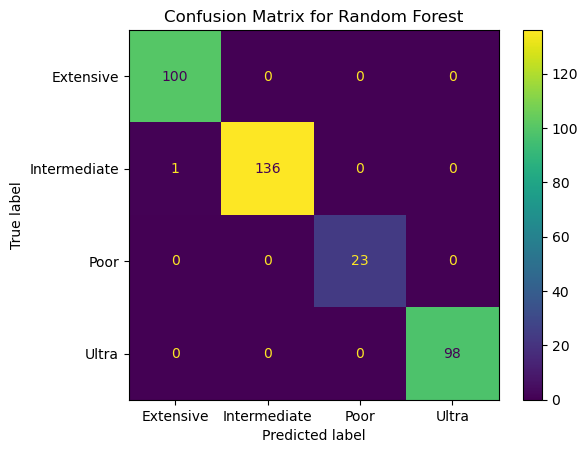


Classification Report for Gradient Boost

              precision    recall  f1-score   support

   Extensive       0.99      1.00      1.00       100
Intermediate       1.00      0.99      1.00       137
        Poor       1.00      1.00      1.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358





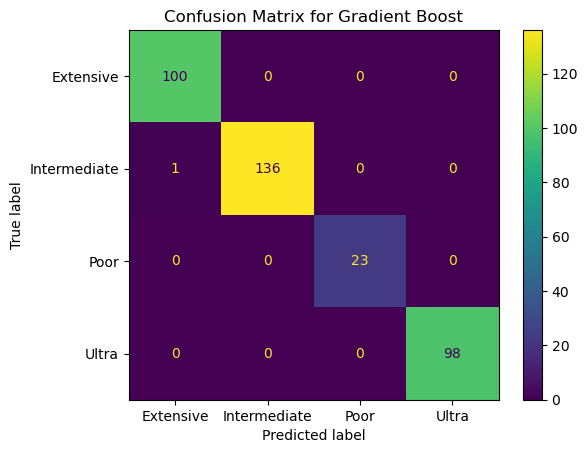


Classification Report for Stochastic Gradient Descent

              precision    recall  f1-score   support

   Extensive       0.99      1.00      1.00       100
Intermediate       1.00      0.99      1.00       137
        Poor       1.00      1.00      1.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358





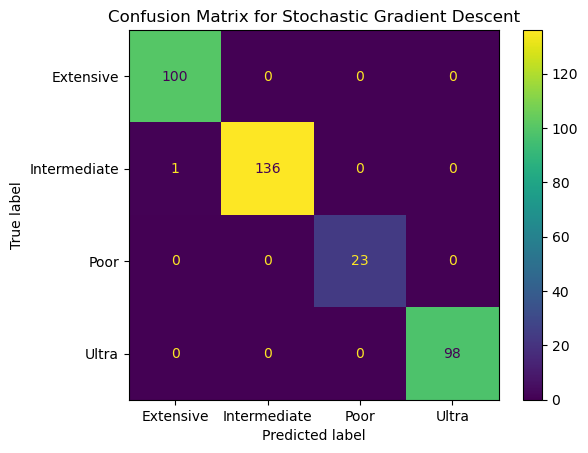


Classification Report for Adaboost

              precision    recall  f1-score   support

   Extensive       0.00      0.00      0.00       100
Intermediate       0.53      1.00      0.69       137
        Poor       0.00      0.00      0.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           0.66       358
   macro avg       0.38      0.50      0.42       358
weighted avg       0.48      0.66      0.54       358





C:\Users\Ananya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ananya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ananya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


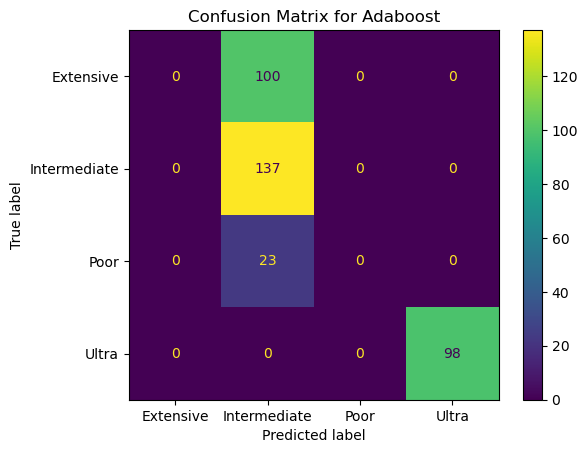


Classification Report for MLP

              precision    recall  f1-score   support

   Extensive       0.99      1.00      1.00       100
Intermediate       1.00      0.99      1.00       137
        Poor       1.00      1.00      1.00        23
       Ultra       1.00      1.00      1.00        98

    accuracy                           1.00       358
   macro avg       1.00      1.00      1.00       358
weighted avg       1.00      1.00      1.00       358





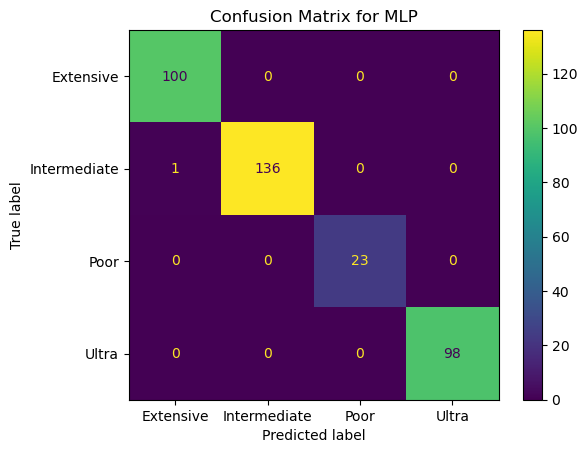

In [8]:
# classification report

for name, model in base_models:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test) #for classification
  conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

  print(f'Classification Report for {name}\n')
  print(classification_report(y_test, y_pred))


  print()
  print()

  cmdisp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=["Extensive","Intermediate","Poor","Ultra"])
  cmdisp.plot()
  plt.title(f'Confusion Matrix for {name}')
  plt.show()
  print()

In [11]:
svm_pipe = Pipeline([('preprocess', prepro_pipe), ('SVM', svm)])

In [12]:
import joblib 
joblib.dump(svm_pipe,'svm_pipe.joblib')


['svm_pipe.joblib']